# Introduction

A l'issue du notebook précédent, nous avons retenu un algorithme de kmeans pour segmenter les clients ayant effectué une seule commande.

Dans ce notebook, nous mesurerons tout d'abord la **robustesse** de l'algorithme à l'aide du score ARI, en vérifiant que relancer plusieurs fois l'algorithme sur le même jeu de données donne des segmentations similaires.

Puis nous mettrons en place une simulation d'un système de **maintenance** afin de déterminer à quel intervalle de temps il est raisonnable de mettre à jour les données d'entraînement du modèle pour conserver des performances satisfaisantes.

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

import os
os.environ["OMP_NUM_THREADS"] = "10"

In [118]:
df = pd.read_csv("csv/segmentation_dataset.csv")

# Conversion de la date au format datetime
df["order_date"] = pd.to_datetime(df["order_date"])

La méthode d'uniformation choisie est la standardisation.

Comme nous utiliserons un pipeline scikit-learn dans la suite, nous devons définir un transformateur adapté.<br>
Il reprend la fonction `standardize` du notebook précédent.

Nous aurions pu utiliser la classe `StandardScaler` de scikit-learn, mais elle ne gère pas le format datetime. Plus précisément les fonctions `mean` et `std` de pandas peuvent être appliquées à une série datetime, mais pas à un dataframe contenant des colonnes datetime (ce que cherche à faire `StandardScaler`).


In [119]:
class Standardizer(BaseEstimator, TransformerMixin) :
    
    def __init__(self) :
        pass

    def fit(self, X, y = None) :
        return self

    def transform(self, X) :
        df = X.copy()
        for feature in df.columns :
            mean = df[feature].mean()
            std = df[feature].std()
            df[feature] = (df[feature] - mean) / std
        return df

# Test de robustesse

On applique deux fois le k-means, puis on affiche le score ARI entre les deux segmentations.

In [120]:
standardizer = Standardizer()
X = standardizer.transform(df[["order_date", "review", "bill_log"]])

kmeans = KMeans(n_clusters = 4, n_init = 10, max_iter = 300)
kmeans_df1 = df.copy()
kmeans_df1["cluster"] = kmeans.fit_predict(X)

kmeans = KMeans(n_clusters = 4, n_init = 10, max_iter = 300)
kmeans_df2 = df.copy()
kmeans_df2["cluster"] = kmeans.fit_predict(X)

In [121]:
ari_score = adjusted_rand_score(kmeans_df1["cluster"], kmeans_df2["cluster"])
print(f"ARI score between these two K-means clusterings : {round(ari_score, 3)}")

ARI score between these two K-means clusterings : 0.978


Afin de visualiser ces deux segmentations, on peut effectuer des t-SNE.<br>
Reprenons une version allégée (standardisation imposée) de la fonction `apply_tsne` du précédent notebook.

In [122]:
def apply_tsne(input_df, perplexity) :
    
    df = input_df.copy()

    standardizer = Standardizer()
    X = standardizer.transform(df[["order_date", "review", "bill_log"]])

    tsne = TSNE(n_components = 2, perplexity = perplexity)
    tsne_result = tsne.fit_transform(X)
    df["tsne_x"] = tsne_result[:, 0]
    df["tsne_y"] = tsne_result[:, 1]
    
    return df

La t-SNE réclamant du temps de calcul, appliquons-la sur un échantillon de 5000 clients.<br>
On veille bien sûr à utiliser le même échantillon pour les deux t-SNE.

In [123]:
sample_size = 5000
sample_indices = df.sample(sample_size).index

sample_df1 = kmeans_df1.loc[sample_indices].copy()
sample_df2 = kmeans_df2.loc[sample_indices].copy()
    
tsne_df1 = apply_tsne(sample_df1, perplexity = 30)
tsne_df2 = apply_tsne(sample_df2, perplexity = 30)

On peut à présent afficher graphiquement les deux segmentations.

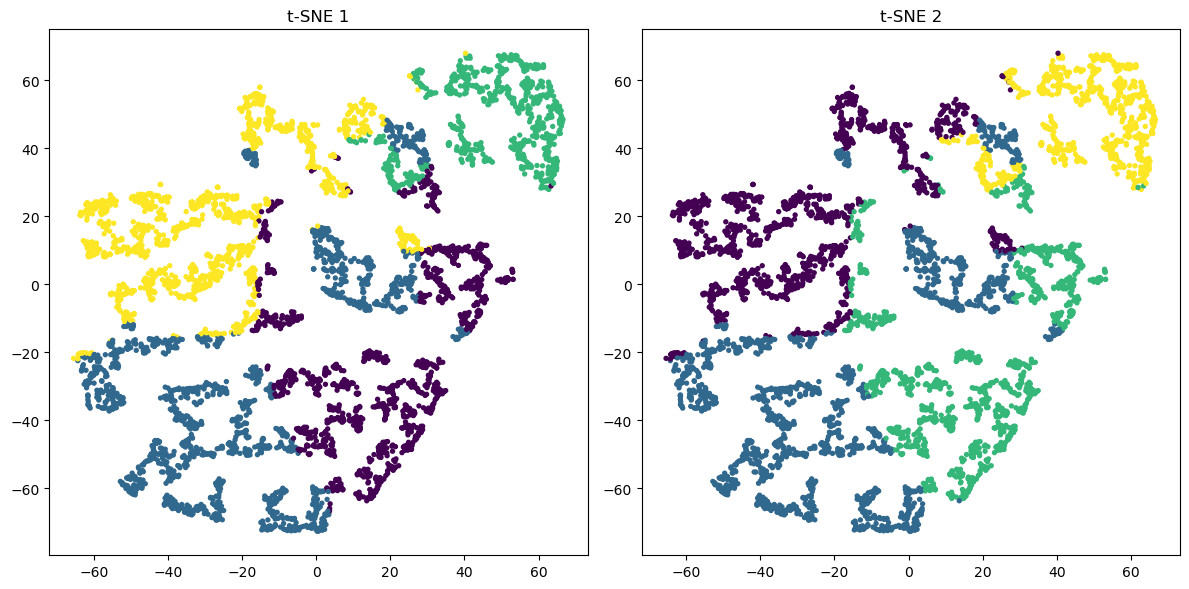

In [124]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

axs[0].set_title('t-SNE 1')
axs[0].scatter(tsne_df1["tsne_x"], tsne_df1["tsne_y"],
               c = tsne_df1["cluster"],
               cmap = "viridis", s = 8)

axs[1].set_title('t-SNE 2')
axs[1].scatter(tsne_df2["tsne_x"], tsne_df2["tsne_y"],
               c = tsne_df2["cluster"],
               cmap = "viridis", s = 8)

plt.tight_layout()
plt.show()

Comme le score ARI proche de 1 le laissait entendre, les deux segmentations sont très semblables.

Les couleurs sont différentes car les deux kmeans n'ont pas numéroté les clusters de la même façon.<br>
Mais justement, l'intérêt du score ARI est qu'il détermine la permutation la plus pertinente de ces numéros de clusters pour mesurer la similarité des segmentations.

# Test de maintenance

Pour simuler un test de maintenance, on coupe le jeu de données (de janvier 2017 à novembre 2018) en deux périodes de temps A et B.

On considère ensuite deux modèles :
- Un premier modèle, qualifié d'ancien modèle, entraîné seulement sur la période A.
- Un second modèle, qualifié de nouveau modèle, entraîné sur toutes les données (périodes A et B).

Les deux modèles effectuerons des prédictions sur les clients de la période B, et on comparera ces prédictions grâce au score ARI. Si ce score est proche de 1, c'est que l'ancien modèle n'a pas besoin d'une actualisation de ses données d'entraînement. Plus il s'éloigne de 1, est plus une mise à jour devient nécessaire.

Afin d'établir à quelle fréquence doivent être effectuées ces mises à jour, on propose de modifier mois par mois la date de fin de la période A (donc de début de la période B) et d'effectuer des simulations pour déterminer le moment où le score ARI passe en-dessous d'un seuil raisonnable (par exemple 0.95).

La fonction `maintenance` ci-dessous effectue une simulation pour des périodes A et B spécifiées en arguments, à partir d'un modèle fourni dans un pipeline. Elle retourne le score ARI correspondant.

In [125]:
def maintenance(X, pipeline, start_date_A, start_date_B, end_date) :
       
    X_A = X[(X["order_date"] >= start_date_A) &
            (X["order_date"] < start_date_B)].copy()
    
    X_B = X[(X["order_date"] >= start_date_B) &
            (X["order_date"] < end_date)].copy()
    
    X_AB = X[(X["order_date"] >= start_date_A) &
             (X["order_date"] < end_date)].copy()
   
    old_model = pipeline.fit(X_A)
    predict_old = old_model.predict(X_B)

    new_model = pipeline.fit(X_AB)
    predict_new = new_model.predict(X_B)

    return adjusted_rand_score(predict_old, predict_new)

La fonction `get_maintenance_scores` ci-dessous effectue les simulations pour tous les choix de périodes fournis via l'argument `dates`.

Cet argument est un dataframe dont les colonnes sont `start_date_A`, `start_date_B` et `end_date`.

La fonction ajoute une colonne `score` à ce dataframe dans laquelle elle stocke les scores ARI de chaque simulation, puis elle retourne le résultat.

In [126]:
def get_maintenance_scores(df, pipeline, dates) :
   
    X = df[["order_date", "review", "bill_log"]].copy()
    
    scores = dates.copy()
    scores["score"] = None
    
    for (index, row) in dates.iterrows() :
        
        score = maintenance(X, pipeline,
                            row["start_date_A"],
                            row["start_date_B"],
                            row["end_date"])
        
        scores.at[index, "score"] = score
    
    return scores

Dans le problème qui nous occupe, nous ferons seulement varier mois par mois a date `start_date_B`, qui correspond à la fin de la période d'entraînement du modèle "ancien".

La fonction `plot_maintenance_scores` ci-dessous affiche graphiquement le score ARI de chaque simulation en fonction de `start_date_B`.

In [127]:
def plot_maintenance_scores(scores, title, score_treshold = 0.8) :
    
    plt.figure(figsize = (12, 5))
    
    plt.plot(scores["start_date_B"],
             scores["score"],
             marker = 'o',
             linestyle = '-',
             color = 'b')
    
    plt.axhline(y = score_treshold,
                color = 'r',
                linestyle = '--',
                label = f"y = {score_treshold}")
    
    plt.title(title)
    plt.xlabel("Date d'arrêt d'entraînement du premier modèle")
    plt.ylabel("Score ARI")
    
    plt.xticks(scores["start_date_B"], rotation = 45)
    plt.grid(True)
    plt.show()

La fonction `get_month_by_month_dates` ci-dessous sert à générer une liste de dates mois par mois d'une date `start_date` à une date `end_date`.

In [128]:
def get_month_by_month_dates(start_date, end_date) :
    
    months = ["01", "02", "03", "04", "05", "06",
              "07", "08", "09", "10", "11", "12"]
    
    month_index = int(start_date[5:7]) - 1
    year = int(start_date[:4])
    
    dates = []
    date = start_date
    
    while date <= end_date :
        dates.append(date)
        month_index += 1
        if month_index == 12 :
            year += 1
            month_index = 0
        date = str(year) + "-" + months[month_index] + start_date[7:]
    
    return dates

On peut maintenant appliquer toute ces fonctions pour effectuer le test de maintenance.<br>
Les dates sont choisies de sorte que les périodes A et B fassent au moins trois mois.

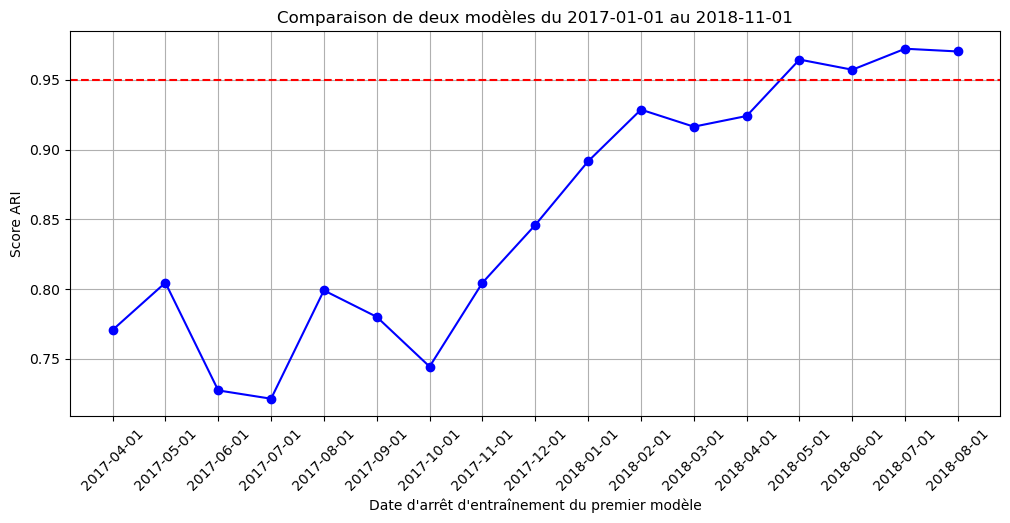

In [129]:
# Pipeline : modèle kmeans à 4 clusters avec une méthode de standardisation
pipeline = Pipeline([
    ('standardizer', Standardizer()),
    ('kmeans', KMeans(n_clusters = 4, n_init = 10, max_iter = 300))
])

# Les dates de début de A et de fin de B sont fixes
start_date = "2017-01-01"
end_date = "2018-11-01"

# Génération des dates (liste de triplets) décrivant les choix de périodes
dates_triplets = [
    (start_date, date, end_date) 
    for date in get_month_by_month_dates("2017-04-01", "2018-08-01")
]

# Conversion en dataframe
dates = pd.DataFrame(
    dates_triplets,
    columns = ["start_date_A", "start_date_B", "end_date"]
)

# Calcul et affichage des scores
scores = get_maintenance_scores(df, pipeline, dates)
title = f"Comparaison de deux modèles du {start_date} au {end_date}"
plot_maintenance_scores(scores, title, score_treshold = 0.95)

Comme attendu, plus la période d'entraînement du premier modèle est grande, donc proche de celle du second (la différence étant la période B), et plus le score ARI est élevé.

Sur le graphique, on a affiché un seuil de 95%, qui revèle qu'à partir de mai 2018, soit un durée inférieure ou égale à 6 mois pour la période B, les deux modèles offrent des prédiction très proches.

Avec un seuil de 90%, on obtiendrait février 2018, soit une période de 9 mois pour la période B.

Il convient de préciser que les fonctions utilisées pour aboutir à ce graphique sont modulables, non seulement pour la valeur de ce seuil, mais aussi et surtout pour la configuration des périodes A et B. On pourrait par exemple augmenter le pas de la subdivision (15 jours au lieu d'un mois) ou encore imposer que A et B aient la même longueur (plutôt que de partager la plage totale).

Ces choix dépendent essentiellement du contexte métier et peuvent être discutés.